# Box Office Mojo Modeller

In [1]:
%pylab inline
#% config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats
sns.set()


from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf 

import matplotlib.pyplot as plt
%matplotlib inline

/Users/kibbles/anaconda3/envs/metis/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


In [2]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

# Import pickled box office data
Very important to take '\_cleaned.pkl' data

In [3]:
path=('./data/mojo_all_years_movies_cleaned.pkl')

In [4]:
df = pd.read_pickle(path)

## Drop films with DTG < \$ 1 mil

count    15973.000000
mean        13.537541
std          3.228295
min          4.276666
25%         10.848482
50%         13.451091
75%         16.468416
max         20.657833
Name: Log_DTG, dtype: float64


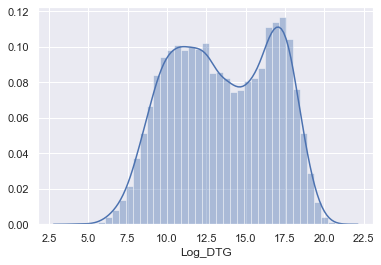

In [5]:
# Examine the current distribution
print(df.Log_DTG.describe())
sns.distplot(df['Log_DTG'])

10.309245424763985


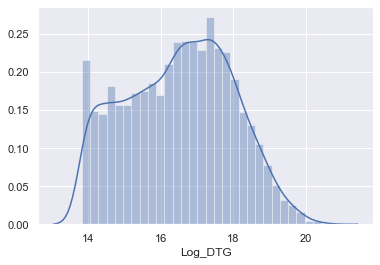

In [6]:
lower_DTG_bound = 1e6
dtg_mean = df.Log_DTG.mean()
dtg_std  = df.Log_DTG.std()
print(dtg_mean - (1*dtg_std))

sns.distplot(df[df.Log_DTG > np.log(lower_DTG_bound) ]['Log_DTG'])

df = df[df.Log_DTG > np.log(lower_DTG_bound) ]

## Drop films with Budget < \$ 1 mil

count    3069.000000
mean       17.212320
std         1.138798
min         9.615805
25%        16.588099
50%        17.312018
75%        17.989898
max        19.690441
Name: Log_Bud, dtype: float64


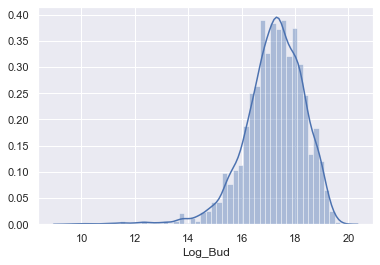

In [45]:
print(df.Log_Bud.describe())
sns.distplot(df['Log_Bud'])

16.073521447100294


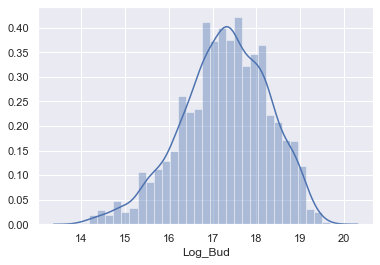

In [46]:
lower_bud_bound = 1e6
bud_mean = df.Log_Bud.mean()
bud_std  = df.Log_Bud.std()
print(bud_mean - (1*bud_std))

sns.distplot(df[df.Log_Bud > np.log(lower_bud_bound) ]['Log_Bud'])

df = df[df.Log_Bud > np.log(lower_bud_bound) ]

## Examine again

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7557 entries, 1 to 15971
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Movie_Title                 7557 non-null   object        
 1   Domestic_Distributor        7527 non-null   object        
 2   Domestic_Total_Gross        7557 non-null   int64         
 3   Runtime                     7370 non-null   float64       
 4   Rating                      5570 non-null   object        
 5   Release_Date                7557 non-null   datetime64[ns]
 6   Budget                      3069 non-null   float64       
 7   Cast1                       7538 non-null   object        
 8   Cast2                       7521 non-null   object        
 9   Cast3                       7512 non-null   object        
 10  Cast4                       7495 non-null   object        
 11  Director                    7537 non-null   object     

In [9]:
df.describe()

,Domestic_Total_Gross,Runtime,Budget,Intercept,Profit_percent,G,NC-17,Not Rated,PG,PG-13,...,Writer_Score,Producer_Score,Cinematographer_Score,Domestic_Distributor_Score,Cast1_Score,Cast2_Score,Cast3_Score,Cast4_Score,Log_DTG,Log_Bud
count,7.557000e+03,7370.000000,3.069000e+03,7557.0,3069.000000,7557.000000,7557.000000,7557.000000,7557.000000,7557.000000,...,7557.000000,7557.000000,7557.000000,7557.000000,7557.000000,7557.000000,7557.000000,7557.000000,7557.000000,3069.000000
mean,3.812380e+07,107.626052,4.868011e+07,1.0,4.606810,0.008866,0.001588,0.000529,0.121080,0.268625,...,7.196003,9.803892,12.550132,15.341213,10.899007,8.921413,7.085831,5.532202,16.491758,17.212320
std,6.302730e+07,18.967197,4.723154e+07,0.0,136.735428,0.093747,0.039820,0.023002,0.326242,0.443274,...,8.172795,8.098819,6.465399,3.147874,7.794069,8.124697,8.116288,7.742617,1.472637,1.138798
min,1.000045e+06,61.000000,1.500000e+04,1.0,-0.982722,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.815556,9.615805
25%,4.398989e+06,95.000000,1.600000e+07,1.0,-0.408374,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,12.083707,14.847584,0.000000,0.000000,0.000000,0.000000,15.296885,16.588099
50%,1.594263e+07,104.000000,3.300000e+07,1.0,0.192200,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,14.450764,15.630229,16.454568,15.614849,13.362356,0.000000,0.000000,16.584507,17.312018
75%,4.448004e+07,116.000000,6.500000e+07,1.0,1.273459,0.000000,0.000000,0.000000,0.000000,1.000000,...,16.422939,17.065793,16.826150,16.905714,17.130311,16.705530,16.343858,15.363569,17.610551,17.989898
max,9.366622e+08,271.000000,3.560000e+08,1.0,7193.587333,1.000000,1.000000,1.000000,1.000000,1.000000,...,19.948905,20.092487,19.926202,19.035464,20.657833,20.657833,20.098215,20.657833,20.657833,19.690441


## correlation

In [10]:
df.corr()

,Domestic_Total_Gross,Runtime,Budget,Intercept,Profit_percent,G,NC-17,Not Rated,PG,PG-13,...,Writer_Score,Producer_Score,Cinematographer_Score,Domestic_Distributor_Score,Cast1_Score,Cast2_Score,Cast3_Score,Cast4_Score,Log_DTG,Log_Bud
Domestic_Total_Gross,1.000000,0.206729,0.631153,NaN,0.018035,0.053362,-0.021404,-0.013107,0.122832,0.180511,...,0.197142,0.187458,0.130350,0.225921,0.194156,0.185312,0.176654,0.163041,0.723855,0.468018
Runtime,0.206729,1.000000,0.317195,NaN,-0.033405,-0.085206,-0.001462,0.025340,-0.116469,0.051030,...,0.111029,0.104915,0.149818,-0.015873,0.150614,0.137692,0.101191,0.081694,0.119242,0.298453
Budget,0.631153,0.317195,1.000000,NaN,-0.031908,0.032669,-0.021940,-0.018267,0.129296,0.209104,...,0.238972,0.193591,0.141580,0.228605,0.235512,0.224061,0.203106,0.191939,0.561326,0.796759
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Profit_percent,0.018035,-0.033405,-0.031908,NaN,1.000000,0.001761,-0.001350,-0.000444,-0.007685,-0.022247,...,-0.028317,-0.038741,-0.068160,-0.005480,-0.050182,-0.039475,-0.030569,-0.024535,0.025891,-0.168364
G,0.053362,-0.085206,0.032669,NaN,0.001761,1.000000,-0.003772,-0.002177,-0.035104,-0.057319,...,-0.014871,-0.033339,-0.095425,-0.004313,-0.025012,-0.036058,-0.033766,-0.014333,0.040861,0.015074
NC-17,-0.021404,-0.001462,-0.021940,NaN,-0.001350,-0.003772,1.000000,-0.000918,-0.014802,-0.024169,...,-0.005106,-0.005846,-0.000347,-0.012028,-0.012829,-0.013818,-0.003766,-0.024471,-0.042809,-0.021853
Not Rated,-0.013107,0.025340,-0.018267,NaN,-0.000444,-0.002177,-0.000918,1.000000,-0.008541,-0.013947,...,0.000563,-0.007670,0.006579,-0.040640,-0.012499,-0.005190,-0.010128,0.003795,-0.030217,-0.055531
PG,0.122832,-0.116469,0.129296,NaN,-0.007685,-0.035104,-0.014802,-0.008541,1.000000,-0.224939,...,-0.003705,0.011394,-0.054686,0.049806,-0.018816,0.003245,0.024677,0.036874,0.130024,0.113298
PG-13,0.180511,0.051030,0.209104,NaN,-0.022247,-0.057319,-0.024169,-0.013947,-0.224939,1.000000,...,0.107215,0.132693,0.161482,0.075438,0.134955,0.120267,0.117795,0.116168,0.199801,0.199799


# Define subset

In [47]:
subset = ['Log_DTG','Intercept','Log_Bud','Runtime','Domestic_Distributor_Score','Cast1_Score','Director_Score','Writer_Score','Producer_Score'] 
# ,'Director_Score','Writer_Score','Producer_Score'


In [48]:
features = df[subset]
features = features.dropna()
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2979 entries, 1 to 15967
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Log_DTG                     2979 non-null   float64
 1   Intercept                   2979 non-null   int64  
 2   Log_Bud                     2979 non-null   float64
 3   Runtime                     2979 non-null   float64
 4   Domestic_Distributor_Score  2979 non-null   float64
 5   Cast1_Score                 2979 non-null   float64
 6   Director_Score              2979 non-null   float64
 7   Writer_Score                2979 non-null   float64
 8   Producer_Score              2979 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 232.7 KB


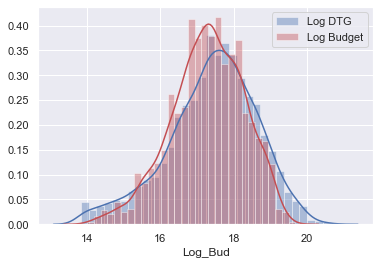

In [49]:
sns.distplot(features['Log_DTG'])
sns.distplot(features['Log_Bud'],color='r')
plt.legend(['Log DTG','Log Budget']);

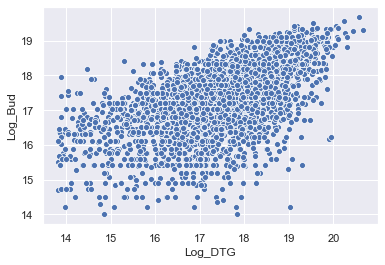

In [50]:
sns.scatterplot(x=features['Log_DTG'], y=features['Log_Bud'])

## Pairplot of Subset

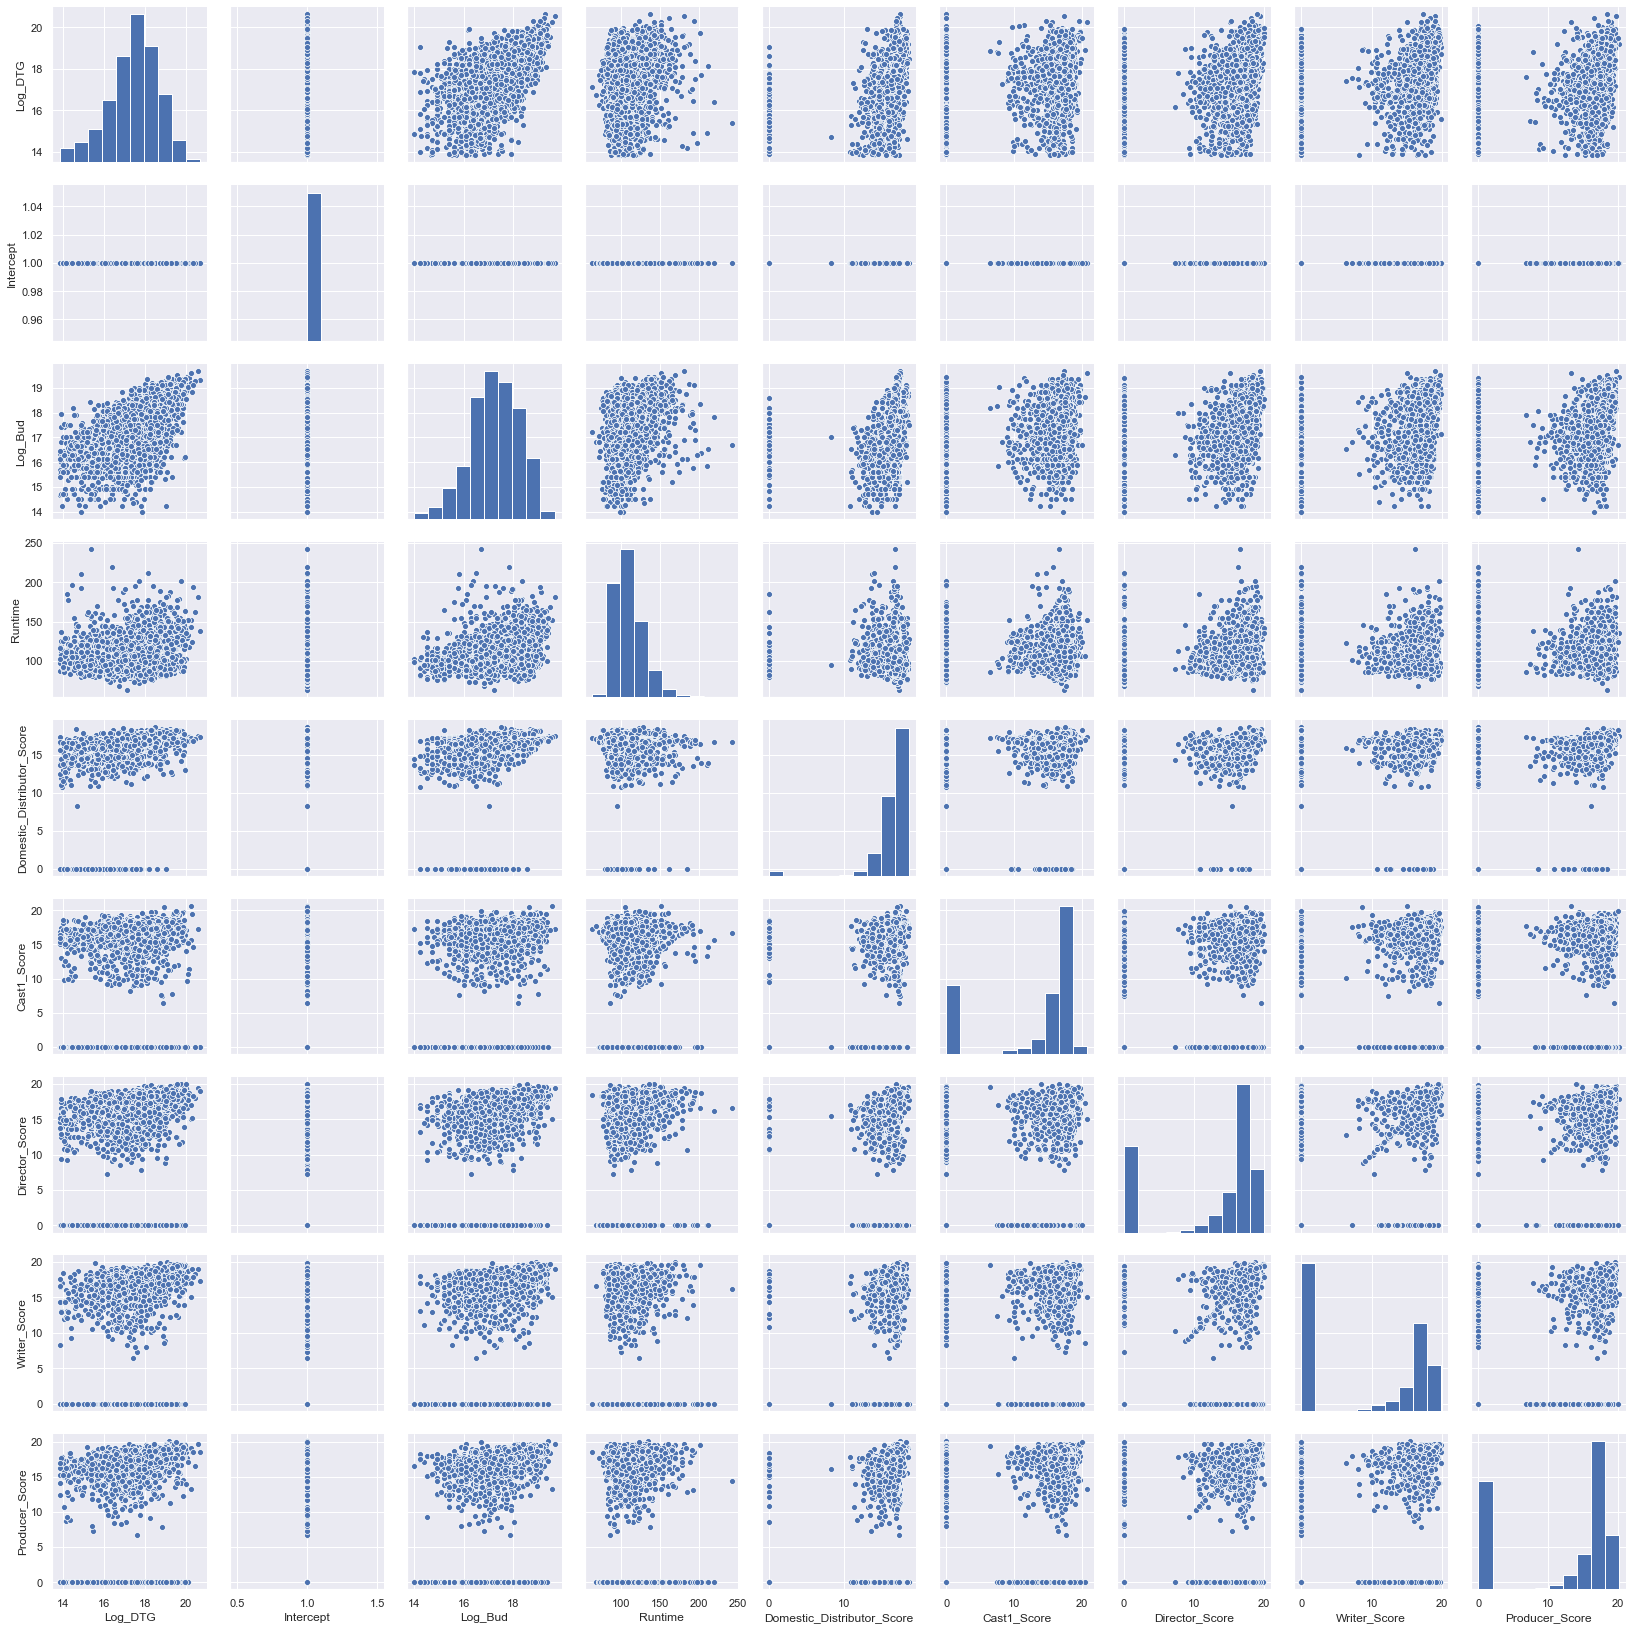

In [51]:
sns.pairplot(features)

# Models

## Split into training/validation/test sets

In [52]:
X = features.loc[:, features.columns != 'Log_DTG']
y = features['Log_DTG']

In [53]:
#Split the data 80 - 20 train/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=np.random.randint(1,100))

(print(#'Training cols: ',X_train.columns,'\n',
       ' Train+Val set dims:   ', X_train_val.shape,'\n',
       'Testing set dims:    ', X_test.shape,'\n',
))

 Train+Val set dims:    (2383, 8) 
 Testing set dims:     (596, 8) 



## statsmodels OLS

### Model set-up

In [54]:
# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=np.random.randint(1,100))
(print(#'Training cols: ',X_train.columns,'\n',
       ' Training set dims:   ', X_train.shape,'\n',
       'Validation set dims: ', X_val.shape,'\n',
       'Testing set dims:    ', X_test.shape,'\n',
))

 Training set dims:    (1787, 8) 
 Validation set dims:  (596, 8) 
 Testing set dims:     (596, 8) 



In [55]:
# Create your model
model = sm.OLS(y_train, X_train) #sm.add_constant(scaler.fit_transform(X_train)))

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Log_DTG   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     125.4
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          4.73e-150
Time:                        15:49:11   Log-Likelihood:                -2525.6
No. Observations:                1787   AIC:                             5067.
Df Residuals:                    1779   BIC:                             5111.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      5.6137      0.445     12.612      0.000       4.741       6.487
Log_Bud                        0.5923      0.029     20.635      0.000       0.536       0.649
Runtime                        0.0029      0.001      2.252      0.024       0.000       0.005
Domestic_Distributor_Score     0.0739      0.010      7.307      0.000       0.054       0.094
Cast1_Score                   -0.0037      0.004     -1.047      0.295      -0.011       0.003
Director_Score                -0.0044      0.004     -1.242      0.215      -0.011       0.003
Writer_Score                   0.0100      0.003      3.425      0.001       0.004       0.016
Producer_Score                 0.0045      0.003      1.429      0.153      -0.002       0.011
==============================================================================
Omnibus:                       59.214   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.083
Skew:                          -0.374   Prob(JB):                     8.19e-17
Kurtosis:                       3.660   Cond. No.                     2.21e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Statsmodels residuals analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


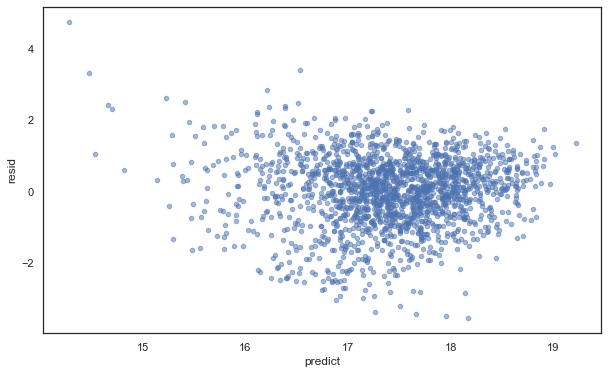

In [56]:
# create residual plot
residuals = pd.DataFrame()
residuals['predict']=fit.predict(X_train)
residuals['resid']= y_train-residuals.predict
with sns.axes_style('white'):
    plot = residuals.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6));

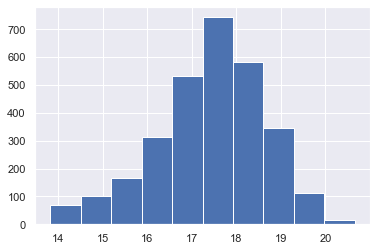

In [57]:
features.Log_DTG.hist();

## sklearn LR KFolds

In [58]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()
lm_reg = Ridge(alpha=1000)

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.34341317, 0.44126316, 0.39448683, 0.33827485, 0.12266353])

In [59]:
kf = KFold(n_splits=5, shuffle=True, random_state = np.random.randint(1,100))
scoring_dict = {'R2':   'r2',
                'MAE':  'neg_mean_absolute_error',
                'RMSE': 'neg_root_mean_squared_error'
               }
for score in scoring_dict:
    print('Linear Regression val',score,f': {np.mean(cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring=scoring_dict[score])):.3f}')
    print('Ridge Regularization val',score,f': {np.mean(cross_val_score(lm_reg, X_train_val, y_train_val, cv=kf, scoring=scoring_dict[score])):.3f}')
    print('\n')

Linear Regression val R2 : 0.329
Ridge Regularization val R2 : 0.299


Linear Regression val MAE : -0.777
Ridge Regularization val MAE : -0.799


Linear Regression val RMSE : -0.997
Ridge Regularization val RMSE : -1.020




## QQ plot

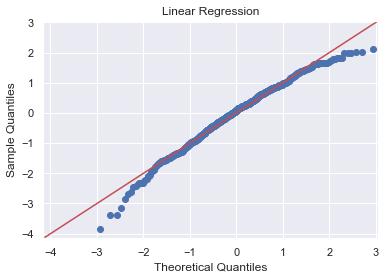

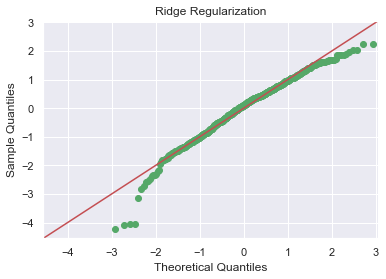

In [60]:
import pylab as py

lm.fit(X_train_val, y_train_val)
sm.qqplot(lm.predict(X_test), line='45', fit=True)
plt.title('Linear Regression')
py.show()

lm_reg.fit(X_train_val, y_train_val)
sm.qqplot(lm_reg.predict(X_test), line='45', fit=True, color='g')
plt.title('Ridge Regularization')
py.show()

Model seems to be doing poorly around outliers: Blue dots should be right on red line.

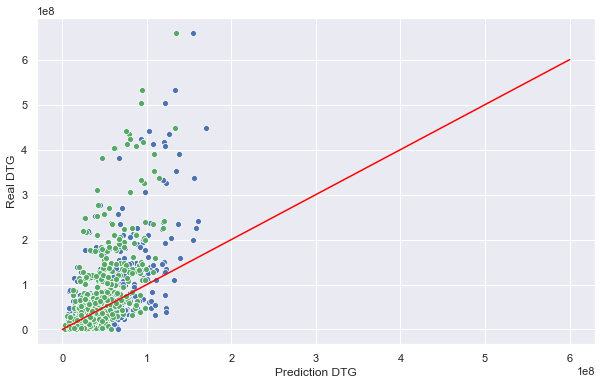

In [61]:
# Prediction vs Reality.
plt.figure(figsize=(10,6))
sns.scatterplot(x=np.exp(lm.predict(X_test)), y=np.exp(y_test))
sns.scatterplot(x=np.exp(lm_reg.predict(X_test)), y=np.exp(y_test), color='g')
plt.xlabel('Prediction DTG'); plt.ylabel('Real DTG')
plt.plot((0,6e8), (0,6e8), c='red');